# Global setup

In [1]:
%matplotlib inline

In [2]:
%pwd

'/home/gabe/work/fast-ai/nbs'

### Library imports

In [4]:
import os
import sys
import json
import numpy as np
from glob import glob
from matplotlib import pyplot as plt
from importlib import reload

### Library setup

In [5]:
np.set_printoptions(precision=4, linewidth=100)
sys.path.append(r'../src')

### Local imports

In [11]:
import utils.utils
reload(utils.utils)

import utils.plothelper
reload(utils.plothelper)

import utils.train_vgg16.py
reload(utils.train_vgg16.py)

from utils.trainhelper import *
from utils.plothelper import *
from utils.utils import *
from utils.train_vgg16 import *

from PIL import Image

ModuleNotFoundError: No module named 'utils.train_vgg16.py'; 'utils.train_vgg16' is not a package

### Train model and save results

In [6]:
train_and_test(no_of_epochs=3)

574029824/574710816 [============================>.] - ETA: 0sFound 23000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.
Running epoch: 0
Epoch 1/1
360/360 [==============================] - 111s - loss: 0.4806 - acc: 0.9597 - val_loss: 0.6498 - val_acc: 0.9515
Running epoch: 1
Epoch 1/1
360/360 [==============================] - 106s - loss: 0.4350 - acc: 0.9673 - val_loss: 0.4721 - val_acc: 0.9615
Running epoch: 2
Epoch 1/1
360/360 [==============================] - 107s - loss: 0.3868 - acc: 0.9724 - val_loss: 0.5474 - val_acc: 0.9630
Completed 3 fit operations
Found 12500 images belonging to 1 classes.


(<keras.preprocessing.image.DirectoryIterator at 0x7fcc6fd704a8>,
 array([[ 0.,  1.],
        [ 1.,  0.],
        [ 0.,  1.],
        ..., 
        [ 1.,  0.],
        [ 1.,  0.],
        [ 0.,  1.]], dtype=float32))

### Load predictions

['../data/test/unknown/532.jpg', '../data/test/unknown/10860.jpg', '../data/test/unknown/5928.jpg', '../data/test/unknown/11799.jpg', '../data/test/unknown/9775.jpg']
[[ 0.  1.]
 [ 1.  0.]
 [ 0.  1.]
 [ 0.  1.]
 [ 0.  1.]]


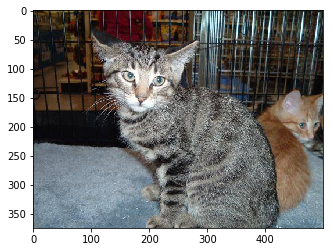

In [7]:
DATA_DIR = '../data'
TEST_DIR = DATA_DIR + '/test'

filenames, test_preds = load_pred_data()
paths = list(map(lambda x: TEST_DIR + '/' + x, filenames))

print(paths[:5])
print(test_preds[:5])

show_image(paths[1])

### Load weights and generate predictions

In [9]:
V_BATCH_SIZE = 4

t_batches = get_batches(DATA_DIR + '/train', batch_size=V_BATCH_SIZE)
v_batches = get_batches(DATA_DIR + '/valid', shuffle=False, batch_size=V_BATCH_SIZE, class_mode=None)
v_filenames = v_batches.filenames
v_classes = v_batches.classes

vgg = Vgg16()
vgg.finetune(v_batches)
vgg.model.load_weights(DATA_DIR + '/results/ft2-2017.10.03.h5')

v_steps = int(np.ceil(v_batches.samples / V_BATCH_SIZE))
v_predictions = vgg.model.predict_generator(v_batches, v_steps)

v_preds_rounded = v_predictions[:,0]
v_labels = np.round(1 - v_preds_rounded)

Found 23000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.


In [10]:
from keras.preprocessing import image

def plots_idx(idx, titles=None):
    plots([image.load_img(DATA_DIR + '/valid/' + v_filenames[i]) for i in idx], titles=titles)

### Inspect correct predictions

found 1921 correct labels


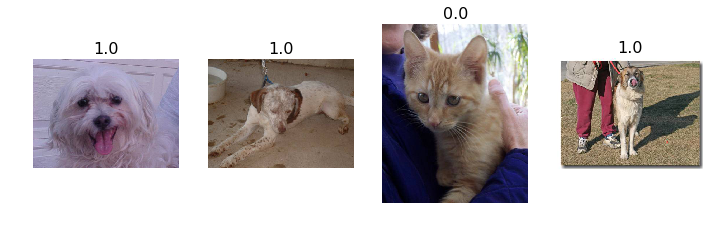

In [11]:
NUM_VIEW = 4

correct = np.where(v_labels == v_classes)[0]
print("found %d correct labels" % len(correct))

c_idx = np.random.permutation(correct)[:NUM_VIEW]
plots_idx(c_idx, v_labels[c_idx])

### Inspect incorrect predictions

found 79 incorrect labels


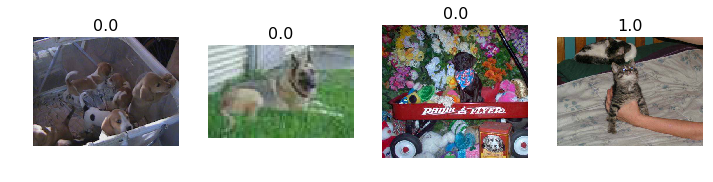

In [12]:
incorrect = np.where(v_labels != v_classes)[0]
print("found %d incorrect labels" % len(incorrect))

i_idx = np.random.permutation(incorrect)[:NUM_VIEW]
plots_idx(i_idx, v_labels[i_idx])

### Inspect incorrect cats

found 48 incorrect cats labels


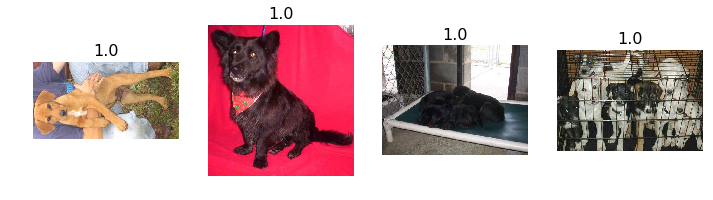

In [13]:
incorrect_cats = np.where((v_labels == 0) & (v_labels != v_classes))[0]
print("found %d incorrect cats labels" % len(incorrect_cats))

most_incorrect_cats = np.argsort(v_preds_rounded[incorrect_cats])[::-1][:NUM_VIEW]
plots_idx(incorrect_cats[most_incorrect_cats], v_preds_rounded[incorrect_cats][most_incorrect_cats])

### Inspect correct cats

found 974 confident correct cats labels


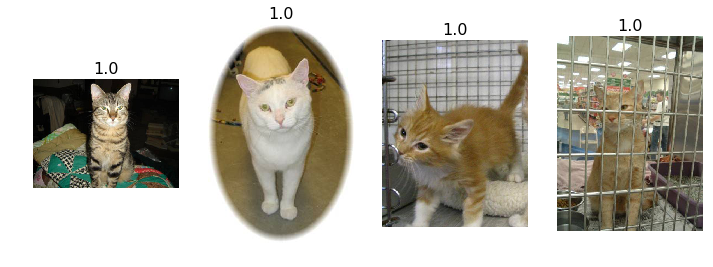

In [14]:
correct_cats = np.where((v_labels == 0) & (v_labels == v_classes))[0]
print("found %d confident correct cats labels" % len(correct_cats))

most_correct_cats = np.argsort(v_preds_rounded[correct_cats])[::-1][:NUM_VIEW]
plots_idx(correct_cats[most_correct_cats], v_preds_rounded[correct_cats][most_correct_cats])

### Inspect correct dogs

found 947 confident correct dogs labels


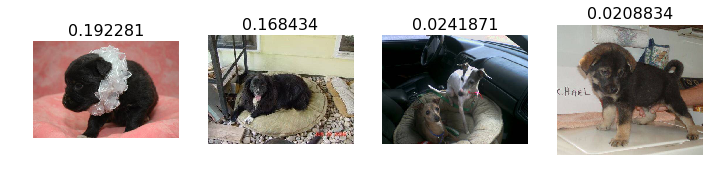

In [15]:
correct_dogs = np.where((v_labels == 1) & (v_labels == v_classes))[0]
print("found %d confident correct dogs labels" % len(correct_dogs))

most_correct_dogs = np.argsort(v_preds_rounded[correct_dogs])[::-1][:NUM_VIEW]
plots_idx(correct_dogs[most_correct_dogs], v_preds_rounded[correct_dogs][most_correct_dogs])

### Inspect incorrect dogs

found 31 incorrect dogs labels


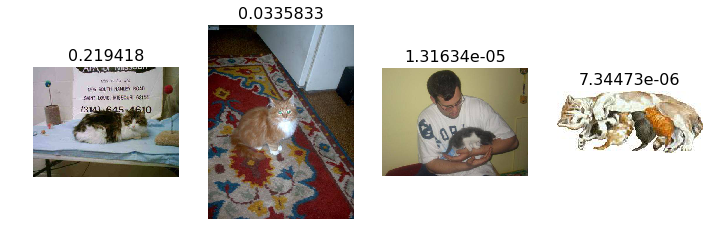

In [16]:
incorrect_dogs = np.where((v_labels == 1) & (v_labels != v_classes))[0]
print("found %d incorrect dogs labels" % len(incorrect_dogs))

most_incorrect_dogs = np.argsort(v_preds_rounded[incorrect_dogs])[::-1][:NUM_VIEW]
plots_idx(incorrect_dogs[most_incorrect_dogs], v_preds_rounded[incorrect_dogs][most_incorrect_dogs])

### Inspect most uncertain

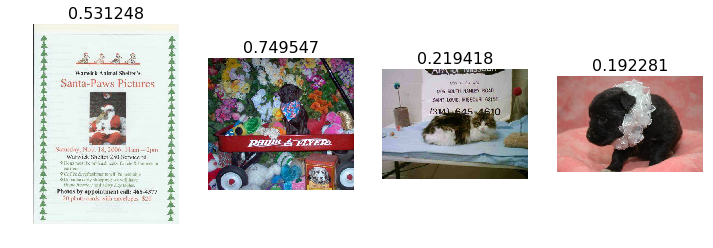

In [17]:
most_uncertain = np.argsort(np.abs(v_preds_rounded - 0.5))
plots_idx(most_uncertain[:NUM_VIEW], v_preds_rounded[most_uncertain])

### Confusion matrix

[[974  31]
 [ 48 947]]


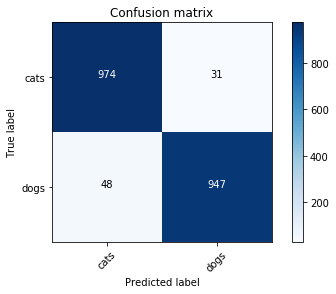

In [18]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(v_classes, v_labels)

plot_confusion_matrix(cm, v_batches.class_indices)

### Prepare submission file

In [19]:
is_dog = test_preds[:,1]

print(is_dog[:5])
print(is_dog[(is_dog < 0.6) & (is_dog > 0.4)])
print(is_dog[(is_dog == 1) & (is_dog == 0)])

[ 1.  0.  1.  1.  1.]
[ 0.5659  0.4978  0.5517]
[]


In [20]:
is_dog = is_dog.clip(min=0.03, max=0.97)
ids = np.array([int(f[8:f.find('.')]) for f in filenames])

print(ids[:5], is_dog[:5])

subm = np.stack([ids, is_dog], axis=1)
print(subm[:5])

[  532 10860  5928 11799  9775] [ 0.97  0.03  0.97  0.97  0.97]
[[  5.3200e+02   9.7000e-01]
 [  1.0860e+04   3.0000e-02]
 [  5.9280e+03   9.7000e-01]
 [  1.1799e+04   9.7000e-01]
 [  9.7750e+03   9.7000e-01]]


In [21]:
np.savetxt(DATA_DIR + '/results/submission.csv', subm, fmt='%d,%.5f', header='id,label', comments='')

In [33]:
from vgg19 import VGG19

vgg = VGG19()

print(vgg.inputs[0].shape)

# from vgg16_old import Vgg16

# vgg2 = Vgg16()


(?, 224, 224, 3)


In [35]:
vgg.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_13 (InputLayer)        (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________